This notebook develops a general framework for estimating and validating trends in a Bayesian setting.

In [1]:
""" Initialize the notebook """
%matplotlib inline
import pylab as PP
import os
import matplotlib as mpl
import collections
import datetime as dt
import cftime
import netCDF4 as nc
import scipy.integrate
import pandas as pd
import numba
import emcee_nompi as emcee
import fastkde.fastKDE as fastKDE
import fastkde.plot
import scipy.stats

# fix a plotting issue with netCDF4
mpl.units.registry[cftime.real_datetime] = mpl.units.registry[dt.datetime]

import numpy as np



#Set the default font for plots
font = { 'family' : 'sans-serif', \
         'size' : '15', \
         'weight' : 'bold'}
mpl.rc('font', **font)

# print any git repository info too
import git
try:
    _repo = git.Repo(search_parent_directories=True)
    _git_sha = _repo.head.object.hexsha
    _git_short_sha = _repo.git.rev_parse(_git_sha, short=7)
    _git_branch = _repo.active_branch
    print("On branch {} at rev {}".format(_git_branch,_git_short_sha))
except:
    print("No repository detected.")

import socket
print("{}:{}".format(socket.gethostname(),os.getcwd()))

No repository detected.
cori13:/global/project/projectdirs/m1517/cascade/taobrien/ClimTrends


In [2]:
""" Get a numba-ready version of erfinv. """
# This follows https://github.com/numba/numba/issues/3086#issuecomment-403469308
import numba.extending
import ctypes

addr = numba.extending.get_cython_function_address("scipy.special.cython_special", "ndtri")
functype = ctypes.CFUNCTYPE(ctypes.c_double, ctypes.c_double)
ndtri_fn = functype(addr)

@numba.vectorize([numba.float64(numba.float64)])
def erfinv(y):
    """numba ufunc implementation of erfinv"""
    return ndtri_fn((y+1)/2.0)/np.sqrt(2)

In [3]:
class ClimTrendModel:
    """A base class for bayesian trend models.  This is meant to be subclassed. """
    
    def __init__(self,
                 dates = None,
                 y = None,
                 test_only = False,
                 use_exponential_model = False,
                 num_walkers = 50,
                 num_burn = 1000,
                ):
        """ 
        
            input:
            ------
                
                dates                 : the input abscissa (time) values.  These should be datetime-like objects.
                                        These will be converted to self.x values, which have units like
                                        'years since the Jan 1 of the earliest year in the dates'.  These
                                        are the values used in the model.
                    
                y                     : the input ordinate values
                
                test_only             : flags whether only internal testing will be done; dates and y are not required if so
                
                use_exponential_model : flags whether to use an exponential, instead of linear, trend.
                
                num_walkers           : the number of walkers to use in the MCMC calculation
                
                num_burn              : the number of samples to use for burn-in
        
        
        """
        
        # *******************
        # store input values
        # *******************
        self.use_exponential_model = use_exponential_model
        self.num_walkers = num_walkers
        self.num_burn = num_burn
        self.test_only = test_only
        
        # store time values
        self.dates = dates
        
        # only process x and y if the test_only flag isn't given
        if not self.test_only:
            # ******************************************
            # convert date values to years-since format
            # ******************************************
            
            if dates is None or y is None:
                raise RuntimeError("dates and y are required as input if the test_only flag is False.")

            # get the smallest date
            min_date = np.min(dates)
            # set the time units
            self.time_units = "days since {yyyy:04}-01-01 00:00:00".format(yyyy = min_date.year)

            # convert the x values to ~years since the earliest date
            self.x = self.dates_to_xvalues( self.dates )

            # if we are using an exponential model, store log(y)
            if self.use_exponential_model:
                self.y = np.log(y)
            else:
                self.y = y
            
            
        # place-holder for the emcee sampler object
        self.sampler = None
            
        # set the number of parameters for this model
        # ( a value of None indicates the model is not set up)
        self.num_parameters = None
        
        # initialize the list indicating which parameters correspond to slopes
        self.parameter_is_slope = []
        
        # initialize the list indicating which parameters are positive-definite
        self.parameter_is_positive_definite = []
        
        # initialize the list indicating which parameters are intercepts
        self.parameter_is_intercept = []
        
        # initialize the list of parameter labels
        self.parameter_labels = []
        
    def sanity_check(self):
        """ Does some sanity checks to make sure that the model implementation makes sense. 
        
            Raises a NotImplementedError if not.
            
            returns self.
        
        """
        if self.num_parameters is None:
            raise NotImplementedError("The subclass must set the self.num_parameters value.")
            
        if len(self.parameter_is_positive_definite) != self.num_parameters:
            raise NotImplementedError("The subclass must fill the self.parameter_is_positive_definite list.")
            
        if len(self.parameter_is_slope) != self.num_parameters:
            raise NotImplementedError("The subclass must fill the self.parameter_is_slope list.")
            
        if len(self.parameter_is_intercept) != self.num_parameters:
            raise NotImplementedError("The subclass must fill the self.parameter_is_intercept list.")
 
        if len(self.parameter_labels) != self.num_parameters:
            raise NotImplementedError("The subclass must fill the self.parameter_labels list.")
        
        # check consistency of parameter flags
        for n in range(self.num_parameters):
            
            # slopes can't be intercepts
            if self.parameter_is_slope[n] and self.parameter_is_intercept[n]:
                raise NotImplementedError("Class implementation has a bug; parameter {} is flagged as being both a slope and an intercept.".format(n))
                
            # slopes can't be positive definite
            if self.parameter_is_slope[n] and self.parameter_is_positive_definite[n]:
                raise NotImplementedError("Class implementation has a bug; parameter {} is flagged as being a slope and being positive definite".format(n))
                
        return self
        
    def dates_to_xvalues(self,
                         dates):
        """ Converts dates to the same units of x values used in the model. 
        
            input:
            ------
                
                dates                 : the input abscissa (time) values.  These should be datetime-like objects.
                
            output:
            -------
            
                x                     : numerical conversions of 'dates' in units of 'years since Jan 01 of the earliest year in the input dates'
        
        """
        
        # convert to days-since units
        days_since = cftime.date2num(dates, self.time_units)
        
        # convert the x values to ~years since the earliest date
        x = days_since / 365.25
        
        return x
        
    def log_prior(self,
                  theta):
        """ Returns the log of the prior. 
        
        input:
        ------
        
            theta  : a vector of the model parameters
            
        output:
        -------
        
            log_prior : the log of the prior probability of the model parameters
        
        This implements a uniform distribution by default (this prior is improper).
        
        """
        
        # check if any of the positive-definite parameters are less than or equal to 0
        for n,parameter in enumerate(theta):
            if self.parameter_is_positive_definite[n]:
                # if so, return NaN to flag that this parameter combination is invalid
                if parameter <= 0:
                    return np.nan
        
        # implement a default prior: an unnormalized uniform distribution equal to 1 everywhere
        return 0.0
    
    def log_likelihood(self,
                       theta):
        """ Returns the log of the likelihood. 
        
        input:
        ------
        
            theta  : a vector of the model parameters
            
        output:
        -------
        
            log_likelihood: the log of the likelihood of the input data, given this parameter set
            
        Note: This is a function of theta, self.x, and self.y
        
        """
        raise NotImplementedError("The subclass must override and implement the log_likelihood() function.")
        
        
    def get_starting_parameters(self):
        """ Returns a set of starting values.
        
            output:
            -------
       
               starting_parameters : starting guesses for the model parameters.
                                     This is a numpy array of shape [self.num_walkers, self.num_parameters]
                
        
        """
        
        # do a sanity check on the model
        self.sanity_check()
       
        # initialize the array of starting parameters
        starting_parameters = np.empty([self.num_walkers, self.num_parameters])
        
        # initialize the parameters
        for n in range(self.num_parameters):
            # make an initial guess between [-2,2)
            guess = np.random.uniform(low = -2, high = 2, size = self.num_walkers) 
            
            # if the parameter is positive-definite, interpret the guess as an exponent
            if self.parameter_is_positive_definite[n]:
                guess = 10**guess
                
            # if the parameter is a slope, interpret the guess as a value with units of %/century
            if self.parameter_is_slope[n]:
                
                # if we are using an exponential model, simply change the units to fraction per year
                guess /= 10000 # convert from %/century to fraction per year
                
                # if we are using a linear model, convert to units of [units_of_y] per year
                if not self.use_exponential_model:
                    guess *= np.average(self.y)
                    
            # if the parameter is an intercept parameter, offset it by the average value of y, 
            # and interpret the guess as a percentage of that value
            if self.parameter_is_intercept[n]:
                guess = (1 + guess/100)*np.average(self.y)
                
            # store the guesses for each walker
            starting_parameters[:, n] = guess
            
        return starting_parameters
                    
    def log_posterior(self, 
                      theta):
        """ Returns the log of the posterior. """
        
        # calculate the prior
        log_prior = self.log_prior(theta)
        # check if the prior is invalid
        if np.isnan(log_prior):
            # simply return -infinity to indicate that this parameter set is not valid
            return -np.inf
            
        # calculate the likelihood
        log_likelihood = self.log_likelihood(theta)
        # check if the likelihood is invalid
        if np.isnan(log_likelihood):
            # simply return -infinity to indicate that this parameter set is not valid
            return -np.inf
        
        # return the posterior
        return log_prior + log_likelihood
    
    def run_mcmc_sampler(self,
                         num_samples = 1000):
        """ Runs the emcee sampler
        
            input:
            ------
            
                num_samples : the number of samples to obtain. This is in addition to self.num_burn
                
            output:
            -------
            
                self
                
                This overrides the self.sampler object, which contains all of the information about the MCMC run.
        """
        # set the number of steps
        num_steps = self.num_burn + num_samples
        
        # set theta randomly
        starting_parameters = self.get_starting_parameters()

        # initialize the MCMC model and do the sampling
        self.sampler = emcee.EnsembleSampler(self.num_walkers, self.num_parameters, self.log_posterior)
        self.sampler.run_mcmc(starting_parameters, num_steps)
        
        return self
    
    def get_mcmc_samples(self):
        """ Gets the MCMC parameter samples. 
        
        
            output:
            -------
                
                emcee_trace : an array of shape [self.num_parameters, num_samples] corresponding to
                              MCMC samples of the parameters
        
        """
        
        emcee_trace = self.sampler.chain[:, self.num_burn:, :].reshape(-1, self.num_parameters).T
        
        return emcee_trace
    
    def get_percentile_of_mean_at_time(self,
                               dates,
                               percentile):
        """ Returns the `percentile' value of the mean at the given date.
        
            input:
            ------
            
                dates      : the input abscissa (time) values.  These should be datetime-like objects. 
                
                percentile : the input percentile value
            
            
            output:
            -------
            
                value      : the 'percentile' value of the mean from the Bayesian model
        
        
        """
        
        raise NotImplementedError("The subclass needs to implement get_percentile_of_mean_at_time().")
        
    def get_percentile_of_percentile_at_time(self,
                               dates,
                               percentile,
                               model_percentile,
                               nskip = 100):
        """ Returns the `percentile' value of the given percentile of the model at the given date.
        
            input:
            ------
            
                dates      : the input abscissa (time) values.  These should be datetime-like objects. 
            
                percentile : the percentile value of model_percentile values to return
                
                model_percentile : the value of percentile to calculate from the statistical model, for each parameter sample
                
                nskip      : the factor by which to reduce the number of samples (via slicing); for saving calculation time.
            
            output:
            -------
            
                value      : the 'percentile' value of the model_percentile from the Bayesian model
        
        
        """
        
        raise NotImplementedError("The subclass needs to implement get_percentile_of_percentiel_at_time().")
        
    def plot_mcmc_trace(self,
                        output_file = None,
                        return_plot = False
                       ):
        """ Plots a set of traces of the MCMC run.
        
            input:
            ------
                
                output_file : an optional output file name
                              (nothing is written if the default None is provided)
                              
                return_plot : flags whether to return the fig, axs objects
                              for further plot modification.
                              
            output:
            -------
            
                self or (fig, axs) : if return_plot is False, the given object instance is returned.
                                     a tuple of (matplotlib.figure, [matplotlib.axes]) values is returned 
                                     otherwise.
            
                Produces a matplotlib plot and possibly writes it to disk.
                
        
        """
        
        fig, axs = PP.subplots(self.num_parameters, 1, figsize = (8, 4*self.num_parameters))
        
        for i in range(self.num_parameters):
            for n in range(self.sampler.chain.shape[0]):
                axs[i].plot(range(self.sampler.chain.shape[1]),self.sampler.chain[n,:,i],'k-',alpha=0.1)
                
                
            # use a log scale for positive definite parameters
            if self.parameter_is_positive_definite[i]:
                axs[i].set_yscale('log')
                
            axs[i].set_ylabel(self.parameter_labels[i])
            
        axs[-1].set_xlabel("Step Number")
        
        # plot a vertical line indicating the end of burn-in
        for ax in axs:
            ylim = ax.get_ylim()
            ax.plot(2*[self.num_burn], ylim, 'k--', alpha = 0.8)
            ax.set_ylim(ylim)
            
        if output_file is not None:
            PP.savefig(output_file)
            
        if return_plot:
            return fig, axs
        else:
            PP.show() 
            return self
            
    def plot_timeseries(self,
                        output_file = None,
                        return_plot = False
                       ):
        """ Plots a timeseries of the data and the model mean.
        
            input:
            ------
                
                output_file : an optional output file name
                              (nothing is written if the default None is provided)
                              
                return_plot : flags whether to return the fig, axs objects
                              for further plot modification.
                              
            output:
            -------
            
                self or (fig, ax) : if return_plot is False, the given object instance is returned.
                                     a tuple of (matplotlib.figure, matplotlib.axes) values is returned 
                                     otherwise.
            
                Produces a matplotlib plot and possibly writes it to disk.
                
        
        """
        
        fig, ax = PP.subplots(figsize = (8, 4))
        
        
        yvals = self.y
        if self.use_exponential_model:
            yvals = np.exp(yvals)
        
        # plot the points
        ax.plot(self.dates, yvals, 'k.')
        
        # get a set of regularly-spaced date points for plotting
        tbnds = self.dates_to_xvalues([min(self.dates), max(self.dates)])
        line_times = np.linspace(tbnds[0], tbnds[1])*365.25
        line_dates = nc.num2date(line_times, self.time_units)
        
        # get the 5, 95, and 50th percentiles of the mean
        mean_50 = self.get_percentile_of_mean_at_time(line_dates, 50)
        mean_5 = self.get_percentile_of_mean_at_time(line_dates, 5)
        mean_95 = self.get_percentile_of_mean_at_time(line_dates, 95)
        
        # plot these
        ax.plot(line_dates, mean_50, color = 'C0')
        ax.fill_between(line_dates, mean_5, mean_95, alpha = 0.5, color = 'C0')
        
        for model_pval in [5, 95]:
            model_pval_50 = self.get_percentile_of_percentile_at_time(line_dates, 50, model_pval, nskip = 1)
            model_pval_5 = self.get_percentile_of_percentile_at_time(line_dates, 5, model_pval, nskip = 1)
            model_pval_95 = self.get_percentile_of_percentile_at_time(line_dates, 95, model_pval, nskip = 1)
            
            # plot these
            ax.plot(line_dates, model_pval_50, '--', color = 'C0')
            ax.fill_between(line_dates, model_pval_5, model_pval_95, alpha = 0.5, color = 'C0')
            
            
        if output_file is not None:
            PP.savefig(output_file)
            
        if return_plot:
            return fig, ax
        else:
            PP.show() 
            return self
        
    def plot_pairplots(self,
                        output_file = None,
                        return_plot = False
                       ):
        """ Plots pairplots of the samples
        
            input:
            ------
                
                output_file : an optional output file name
                              (nothing is written if the default None is provided)
                              
                return_plot : flags whether to return the fig, axs objects
                              for further plot modification.
                              
            output:
            -------
            
                self or (fig, axs) : if return_plot is False, the given object instance is returned.
                                     a tuple of (matplotlib.figure, [matplotlib.axes]) values is returned 
                                     otherwise.
            
                Produces a matplotlib plot and possibly writes it to disk.
                
        
        """
        
        # get the MCMC samples
        parameter_samples = self.get_mcmc_samples()
        
        auto_show = True
        if return_plot:
            auto_show = False
        
        return_values = fastkde.plot.pair_plot(parameter_samples,
                                               var_names = self.parameter_labels,
                                               auto_show = auto_show)
        
        if return_plot:
            fig, axs, _, _, _ = return_values
           
        if output_file is not None:
            PP.savefig(output_file)
            
        if return_plot:
            return fig, axs
        else:
            PP.show() 
            return self
 
    def plot_nnplot(self,
                    output_file = None,
                    return_plot = False
                    ):
        """ Plots a plot of actual vs expected counts above a threshold
        
            input:
            ------
                
                output_file : an optional output file name
                              (nothing is written if the default None is provided)
                              
                return_plot : flags whether to return the fig, axs objects
                              for further plot modification.
                              
            output:
            -------
            
                self or (fig, ax) : if return_plot is False, the given object instance is returned.
                                     a tuple of (matplotlib.figure, matplotlib.axes) values is returned 
                                     otherwise.
            
                Produces a matplotlib plot and possibly writes it to disk.
                
        
        """
        
        # get the MCMC samples
        parameter_samples = self.get_mcmc_samples()
        
        # set the CDF values for which we will evaluate
        num_cdfs = 100
        cdf_values = np.logspace(np.log10(0.5),np.log10(99.5),num_cdfs)
        #cdf_values = np.array([5,50,95])
        
        # set the percentile values that we'll use for plotting
        mid = 50
        low = 5
        high = 95
        plot_pvalues = (mid, low, high)
        
        # initialize the actual and expected count dictionaries
        actual_counts   = { v : np.empty(num_cdfs, dtype = int) for v in plot_pvalues }
        expected_counts = { v : np.empty(num_cdfs, dtype = int) for v in plot_pvalues }
        
        
        # get the y values
        yvals = self.y
        if self.use_exponential_model:
            yvals = np.exp(yvals)
        
        # get the counts of data above the cdf thresholds
        for n, cdf in enumerate(cdf_values):
            for plot_pvalue in plot_pvalues:
                percentile_values = self.get_percentile_of_percentile_at_time(self.dates, plot_pvalue, cdf)
                
                # get the actual counts
                actual_counts[plot_pvalue][n] = np.sum(yvals > percentile_values)
                
                # estimate the mean of the the expected counts
                expected_count = int((1-cdf/100)*len(self.dates))
                # get the percentile of expected counts, assuming that counts are distributed as a poisson distribution
                expected_counts[plot_pvalue][n] = scipy.stats.poisson.ppf(plot_pvalue/100,mu=expected_count)
                
        fig,ax = PP.subplots(figsize=(8,6))
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.plot(expected_counts[mid], actual_counts[mid],linewidth=3, color = 'C0')
        ax.fill_between(expected_counts[mid], actual_counts[low], actual_counts[high] ,color='C0', alpha=0.5)

        ax.plot(expected_counts[mid], expected_counts[mid], 'k-',linewidth=2, alpha = 0.5)
        ax.fill_betweenx(expected_counts[mid], expected_counts[low], expected_counts[high], color='k', alpha=0.2)

        ax.set_ylim(ax.get_xlim())

        ax.set_xlabel('Expected Count')
        ax.set_ylabel('Actual Count')

        ax.set_title('Data counts above a given quantile')
        
        ax.set_xlim([1, len(self.dates)])
        ax.set_ylim([1, len(self.dates)])

        if output_file is not None:
            PP.savefig(output_file)
            
        if return_plot:
            return fig, ax
        else:
            PP.show() 
            return self      
        
    def generate_samples(self,
                         theta,
                         dates):
        """ Generates samples from the distribution for the given dates.
        
            input:
            ------
            
                theta   : a vector of the model parameters
                
                dates   : the values for which to generate samples
                
            output:
            ------
            
                samples : a numpy array with the same shape as dates
        
        """
        
        raise NotImplementedError("The subclass needs to implement the generate_samples() method.")
        
    def run_model_test(self,
                       theta = None):
        """ Runs a test of the model.
        
            input:
            ------
            
                theta : the true parameters to use in the test
                        This could be None if the test_only flag
                        was set to False
                
            output:
            -------
            
                generates a set of tests
        
        """
        
        
        # use the internal samples if
        # model test parameters were given
        if theta is None:
            if self.test_only:
                raise RuntimeError("the `theta' argument was not provided (is None), but the `test_only' flag was set to True when the object was initialized, so no data are present.")
        else:
            nvals = 100
            time_units = "days since 1918-01-01 00:00:00"
            # save the time units
            self.time_units = time_units
            time_values = np.random.uniform(low = 0, high = 100*365.25, size = nvals).astype(int)
            dates = cftime.num2date(time_values, time_units)
            # set the dates
            self.dates = dates
            self.x = self.dates_to_xvalues(self.dates)
            # generate samples
            self.y = self.generate_samples(theta, dates)
            
        # run the sanity check
        self.sanity_check()
        
        # run the sampler
        self.run_mcmc_sampler()
        
        # ***************
        # plot the trace
        # ***************
        fig, axs = self.plot_mcmc_trace(return_plot = True)
        # plot the true values if given
        if theta is not None:
            for n, val in enumerate(theta):
                xlim = axs[n].get_xlim()
                axs[n].plot(xlim, 2*[val], 'r--', alpha = 0.8)
        PP.show()
        
        # *******************
        # plot the pair plot
        # *******************
        fig, axs = self.plot_pairplots(return_plot = True)
        # plot the true values if given
        if theta is not None:
            for n1 in range(self.num_parameters):
                for n2 in range(n1, self.num_parameters):
                    if n1 != n2:
                        ax = axs[n2,n1]
                        # plot the true parameter values in the 2D plane
                        axs[n2,n1].plot(theta[n1], theta[n2], 'r*')
                        
                # plot a vertical line at the parameter value
                ylim = axs[n1,n1].get_ylim()
                axs[n1, n1].plot(2*[theta[n1]], ylim, 'r--')
                axs[n1, n1].set_ylim(ylim)
        PP.show()
        
        # plot the timeseries
        self.plot_timeseries()
        
        # plot the N-N plot
        self.plot_nnplot()
            
  

In [4]:
@numba.vectorize([numba.float64(numba.float64, numba.float64, numba.float64)])
def log_normal_fast(x, mu, var):
    """  Returns the log of a normal distribution using numpy ufuncs
    
        input:
        ------
            
            x    : the input value to the log of the normal distribution
            
            mu   : the mean of the normal distribution
            
            var  : the variance of the normal distribution
            
        output:
        -------
            
            log_normal : the log of the normal distribution
    
    """
    
    return -0.5*np.log(var*2*np.pi) - (x - mu)**2 / (2*var)
    
@numba.vectorize([numba.float64(numba.float64, numba.float64, numba.float64)])
def normal_ppf_fast(F, mu, var):
    """  Returns the the quantile of percentile value F for a normal distribution
    
        input:
        ------
            
            F    : the percentile value [0-100]
            
            mu   : the mean of the normal distribution
            
            var  : the variance of the normal distribution
            
        output:
        -------
            
            quantile : the value corresponding to percentile F in the normal distribution
    
    """
    
    quantile = mu + np.sqrt(2*var)*erfinv(float(2*F/100 - 1))
    
    return quantile
    

class NoTrendNormalModel(ClimTrendModel):
    """ A simple normal distribution with no trend.
    
    
        Parameters:
        
            theta = ( mean, variance )
    
    """
    
    def __init__(self, *args, **kwargs):
        
        # run the base class initialization
        super().__init__(*args, **kwargs)
        
        self.num_parameters = 2
        self.parameter_is_slope = self.num_parameters*[False]
        self.parameter_is_intercept = [True, False]
        self.parameter_is_positive_definite = [ False, True ]
        self.parameter_labels = ("$\mu$", "$\sigma^2$")
        self.sanity_check()
        
    
    def log_likelihood(self, theta):
        
        mu, var = theta
        
        return np.sum(log_normal_fast(self.y, mu, var))
    
    def get_percentile_of_mean_at_time(self, dates, percentile):
        
        # get the MCMC samples
        parameter_samples = self.get_mcmc_samples()
        
        # check that the MCMC sampler has been run
        if self.sampler is not None:
            
            # get the mean value
            mu = parameter_samples[0,:]
            # get the percentile of that value
            values = np.percentile(mu, percentile)*np.ones(len(dates))
            
            # exponentiate the value if we are using an exponential trend model
            if self.use_exponential_model:
                values = np.exp(values)
        else:
            raise RuntimeError("the `run_mcmc_sampler()' method must be called prior to calling get_percentile_of_mean_at_time()'")
            
        return values
    
    def get_percentile_of_percentile_at_time(self, 
                                             dates,
                                             percentile,
                                             model_percentile,
                                             nskip = 100):
        
        # get the MCMC samples
        parameter_samples = self.get_mcmc_samples()
        
        # subset the MCMC samples to save time
        skip_slice = slice(None,None,nskip)
        parameter_samples = parameter_samples[:,skip_slice]
        
        
        # check that the MCMC sampler has been run
        if self.sampler is not None:
            
            # get the mean value
            mu  = parameter_samples[0,:][:,np.newaxis]*np.ones([len(parameter_samples[0,:]),len(dates)])
            var = parameter_samples[1,:][:,np.newaxis]*np.ones([len(parameter_samples[0,:]),len(dates)])
            
            model_values = normal_ppf_fast(model_percentile, mu, var)
            
            # get the percentile of that value
            values = np.percentile(model_values, percentile, axis = 0)
            
            # exponentiate the value if we are using an exponential trend model
            if self.use_exponential_model:
                values = np.exp(values)
        else:
            raise RuntimeError("the `run_mcmc_sampler()' method must be called prior to calling get_percentile_of_mean_at_time()'")
            
        return values
    
    def generate_samples(self,
                         theta,
                         dates):
        # get the parameters
        mu, var = theta
        
        # convert the dates to the internal years-since format
        times = self.dates_to_xvalues(dates)
        
        # vectorize the mean and variance
        mu  = mu*np.ones(np.shape(dates))
        var = var*np.ones(np.shape(dates))
        
        
        # generate the samples
        samples = np.reshape(np.array( [ scipy.stats.norm.rvs(loc = m, scale = np.sqrt(v)) for m, v in zip(mu, var)] ), 
                             np.shape(dates))
        
        return samples
        
    
    
        
class TrendNormalModel(ClimTrendModel):
    """ A simple normal distribution with trend.
    
    
        Parameters:
        
            theta = ( mean_slope, mean_intercept, variance )
    
    """
    
    def __init__(self, *args, **kwargs):
        
        # run the base class initialization
        super().__init__(*args, **kwargs)
        
        self.num_parameters = 3
        self.parameter_is_slope = [True, False, False]
        self.parameter_is_intercept = [False, True, False]
        self.parameter_is_positive_definite = [ False, False, True ]
        self.parameter_labels = ("$c_{\mu}$", "$\mu_0$", "$\sigma^2$")
        self.sanity_check()
        
    
    def log_likelihood(self, theta):
        
        cmu, mu0, var = theta
        
        mu = cmu*self.x + mu0
        
        return np.sum(log_normal_fast(self.y, mu, var))
    
    def get_percentile_of_mean_at_time(self, dates, percentile):
        
        # get the MCMC samples
        parameter_samples = self.get_mcmc_samples()
        
        # convert the input dates to times
        times = self.dates_to_xvalues(dates)
        
        # check that the MCMC sampler has been run
        if self.sampler is not None:
            
            # get the mean value
            mu = parameter_samples[0][:,np.newaxis]*times[np.newaxis,:] + parameter_samples[1][:,np.newaxis]
            # get the percentile of that value
            values = np.percentile(mu, percentile, axis = 0)
            
            # exponentiate the value if we are using an exponential trend model
            if self.use_exponential_model:
                values = np.exp(values)
        else:
            raise RuntimeError("the `run_mcmc_sampler()' method must be called prior to calling get_percentile_of_mean_at_time()'")
            
        return values
    
    def get_percentile_of_percentile_at_time(self,
                                             dates,
                                             percentile,
                                             model_percentile,
                                             nskip = 100):
        
        # get the MCMC samples
        parameter_samples = self.get_mcmc_samples()
        
        # subset the MCMC samples to save time
        skip_slice = slice(None,None,nskip)
        parameter_samples = parameter_samples[:,skip_slice]
        
        # convert the input dates to times
        times = self.dates_to_xvalues(dates)
        
        # check that the MCMC sampler has been run
        if self.sampler is not None:
            
            # get the mean value
            
            mu  = parameter_samples[0][:,np.newaxis]*times[np.newaxis,:] + parameter_samples[1][:,np.newaxis]
            mu  = mu*np.ones([len(parameter_samples[0,:]),len(dates)])
            var = parameter_samples[2,:][:,np.newaxis]*np.ones([len(parameter_samples[0,:]),len(dates)])
            
            model_values = normal_ppf_fast(model_percentile, mu, var)
            
            # get the percentile of that value
            values = np.percentile(model_values, percentile, axis = 0)
            
            # exponentiate the value if we are using an exponential trend model
            if self.use_exponential_model:
                values = np.exp(values)
        else:
            raise RuntimeError("the `run_mcmc_sampler()' method must be called prior to calling get_percentile_of_mean_at_time()'")
            
        return values
 
    def generate_samples(self,
                         theta,
                         dates):
        # get the parameters
        cmu, mu0, var = theta
        
        # convert the dates to the internal years-since format
        times = self.dates_to_xvalues(dates)
        
        # vectorize the mean and variance
        mu  = cmu*times + mu0
        var = var*np.ones(np.shape(dates))
        
        # generate the samples
        samples = np.reshape(np.array( [ scipy.stats.norm.rvs(loc = m, scale = np.sqrt(v)) for m, v in zip(mu, var)] ), 
                             np.shape(dates))
        
        return samples
 

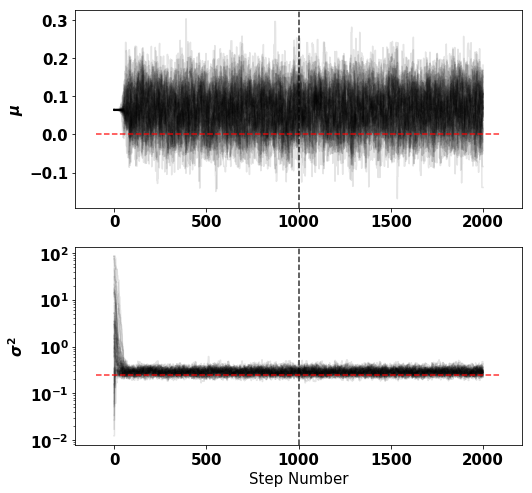

/project/projectdirs/m1949/local/cori/anaconda/anaconda3/lib/python3.6/site-packages/fastkde/fastKDE.py:465: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  *(1+sqrt(1-ecfThresh/ecfSq[iCalcPhi]))
/project/projectdirs/m1949/local/cori/anaconda/anaconda3/lib/python3.6/site-packages/fastkde/fastKDE.py:473: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.phiSC[iCalcPhi] = self.ECF[iCalcPhi]*kappaSC[iCalcPhi]
/project/projectdirs/m1949/local/cori/anaconda/anaconda3/lib/python3.6/site-packages/fastkde/plot.py:124: FutureWarning: Using a non-tu

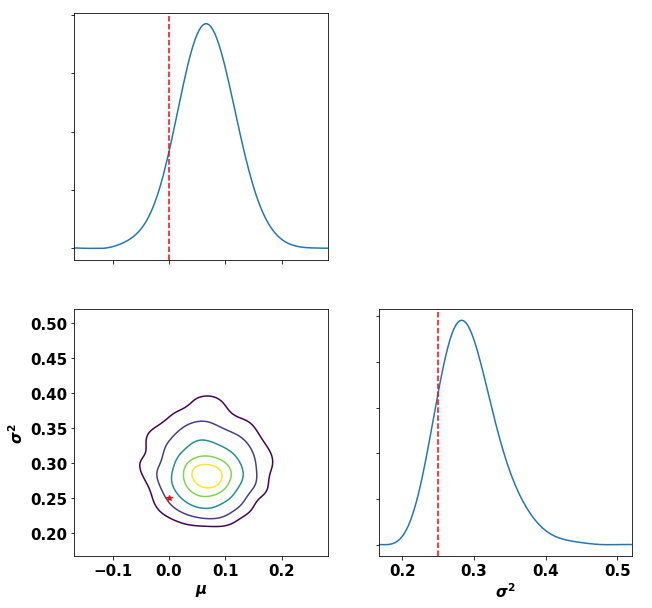

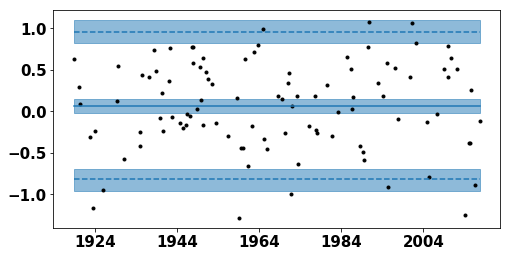

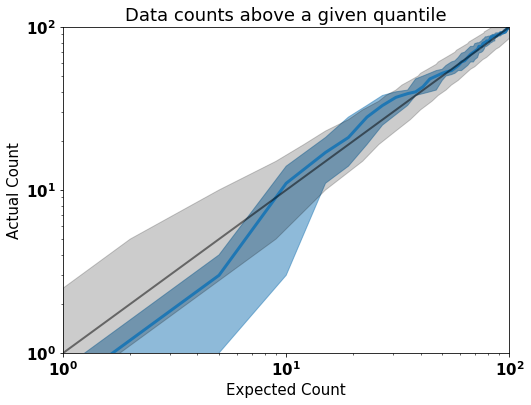

In [5]:
NoTrendNormalModel(test_only = True).run_model_test((0.0, 0.25))

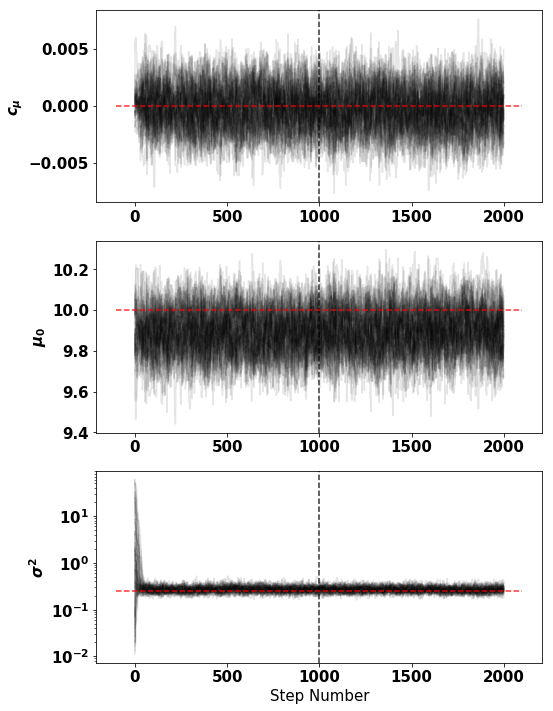

/project/projectdirs/m1949/local/cori/anaconda/anaconda3/lib/python3.6/site-packages/fastkde/fastKDE.py:465: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  *(1+sqrt(1-ecfThresh/ecfSq[iCalcPhi]))
/project/projectdirs/m1949/local/cori/anaconda/anaconda3/lib/python3.6/site-packages/fastkde/fastKDE.py:473: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.phiSC[iCalcPhi] = self.ECF[iCalcPhi]*kappaSC[iCalcPhi]
/project/projectdirs/m1949/local/cori/anaconda/anaconda3/lib/python3.6/site-packages/fastkde/plot.py:124: FutureWarning: Using a non-tu

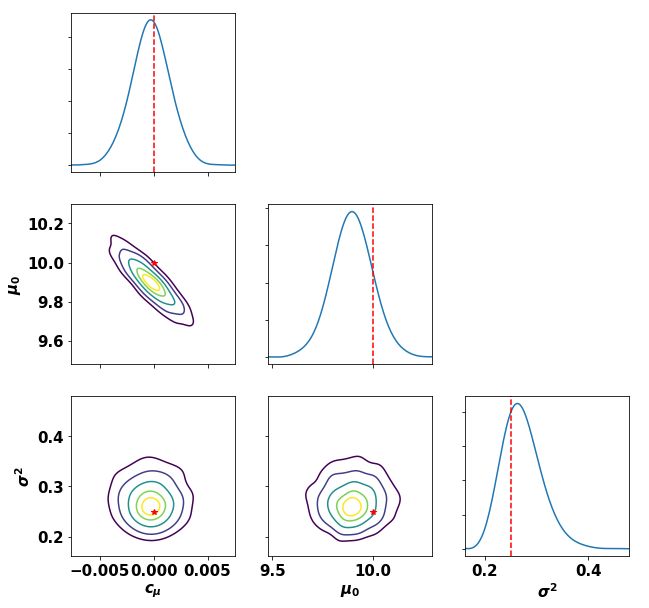

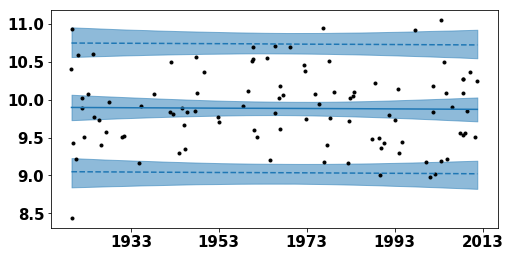

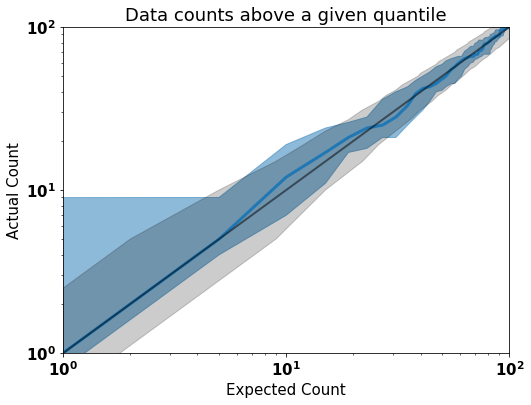

In [6]:
TrendNormalModel(test_only = True).run_model_test((0.0, 10.0, 0.25))

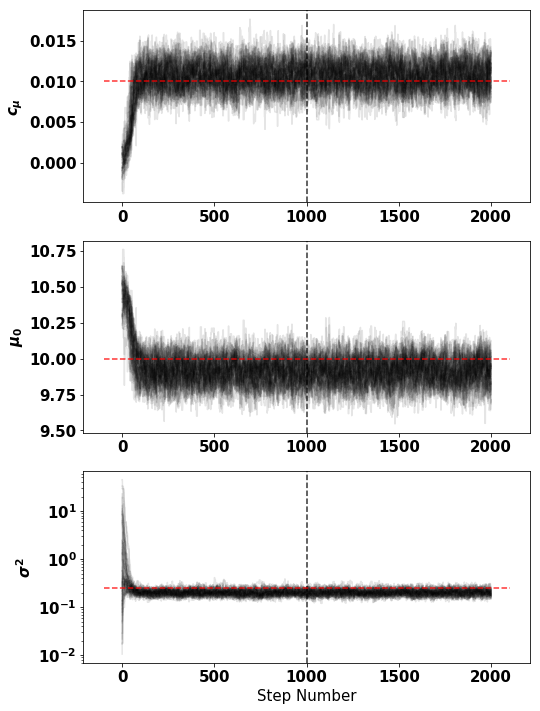

/project/projectdirs/m1949/local/cori/anaconda/anaconda3/lib/python3.6/site-packages/fastkde/fastKDE.py:465: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  *(1+sqrt(1-ecfThresh/ecfSq[iCalcPhi]))
/project/projectdirs/m1949/local/cori/anaconda/anaconda3/lib/python3.6/site-packages/fastkde/fastKDE.py:473: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.phiSC[iCalcPhi] = self.ECF[iCalcPhi]*kappaSC[iCalcPhi]
/project/projectdirs/m1949/local/cori/anaconda/anaconda3/lib/python3.6/site-packages/fastkde/plot.py:124: FutureWarning: Using a non-tu

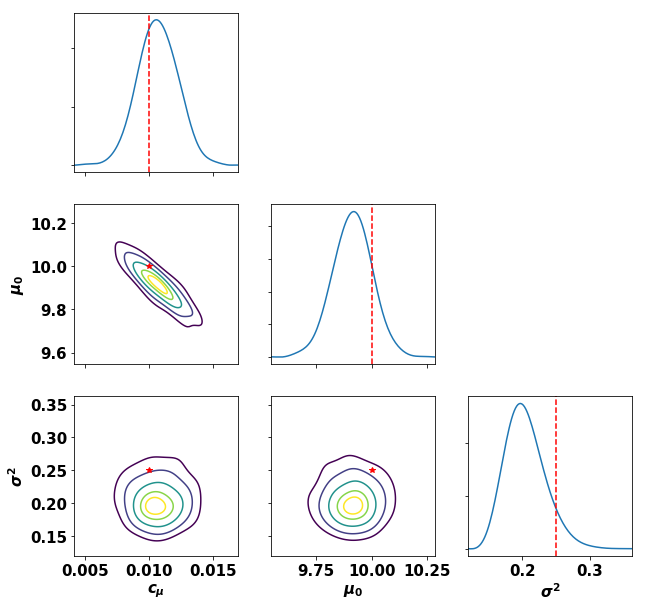

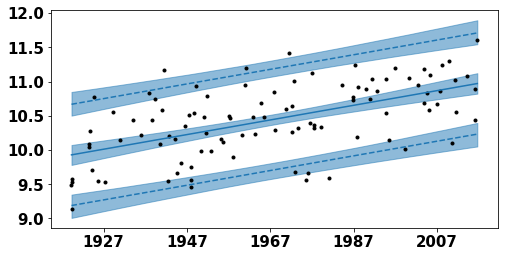

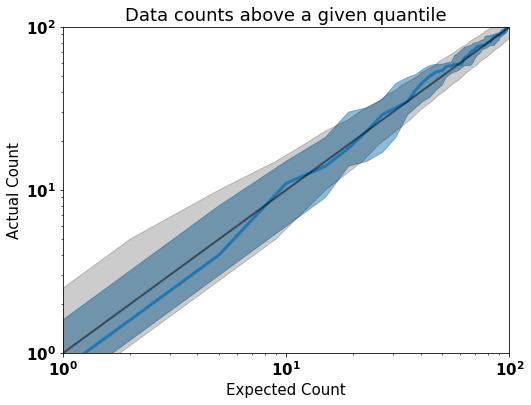

In [7]:
TrendNormalModel(test_only = True).run_model_test((0.01, 10.0, 0.25))